# Stereo Correspondence algorithm optmization

The motivation is taking advantage of numpy optimizations rather than using nested loops for calculating the disparity.

## Import libraries

In [1]:
import numpy as np
import cv2
import time

from matplotlib import pyplot as plt

## How the algorithm works

### The initial values

All the variables and arguments are set here for demonstration of how the algorithm works, step by step.

Populating the interactive namespace from numpy and matplotlib


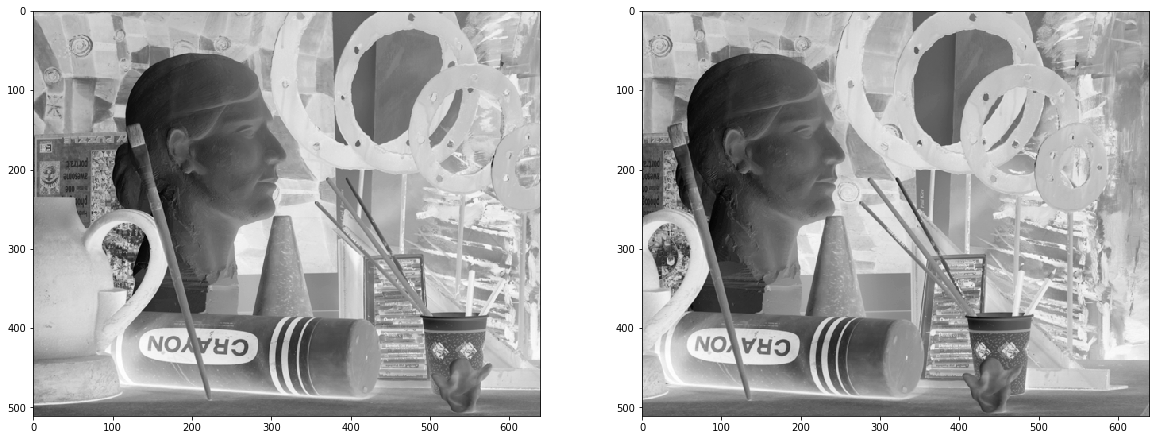

In [2]:
left_image = cv2.imread('input/pair1-L.png', 0)
right_image = cv2.imread('input/pair1-R.png', 0)
    
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

fig, (imgL, imgR) = plt.subplots(1, 2)
imgL.imshow(left_image, cmap = plt.cm.binary)
imgR.imshow(right_image, cmap = plt.cm.binary)

height, width = left_image.shape

### Padding the image with zeros

As we need to split in equal pieces and have the keep the same size as output, one of common pratices is pad the image, basically extend it with zeros, according to the size of the patch.

The formula is $\frac{blockSize - 1}{2}$

In [3]:
block_size = 5
padding = lambda b : (b - 1) // 2

pad_size = padding(block_size)
pad_size

2

In [4]:
def padding_image(image_matrix, block):
    p = padding(block)
    padded = np.pad(image_matrix, ((p, p), (p, p)))
    
    return padded

#### Applying the padding in the images

Populating the interactive namespace from numpy and matplotlib


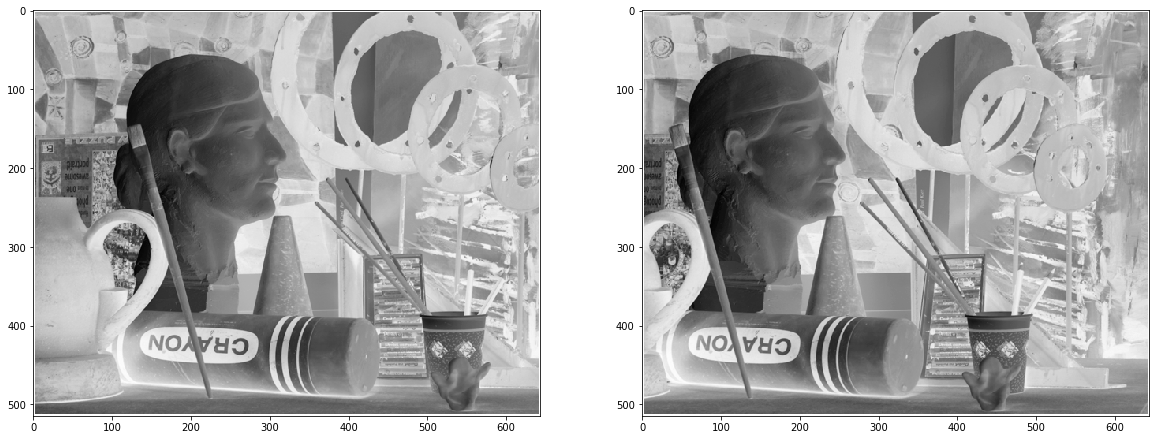

In [5]:
pad_left = padding_image(left_image, block_size)
pad_right = padding_image(right_image, block_size)

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

fig, (imgL, imgR) = plt.subplots(1, 2)
imgL.imshow(pad_left, cmap = plt.cm.binary)
imgR.imshow(pad_right, cmap = plt.cm.binary)

### Extract the patch

Given the image, top-left coordinate and the block size, the matrix is cropped into that specific region

In [6]:
def extract_patch(image, position, block_size):
    x = position[1]
    y = position[0]
    
    width = x + block_size
    height = y + block_size
    
    return image[y:height, x:width]

Populating the interactive namespace from numpy and matplotlib


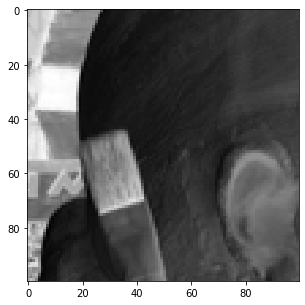

In [7]:
test_block_100 = extract_patch(pad_left, (100, 100), 100)

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 5)
plt.imshow(test_block_100, cmap = plt.cm.binary)

### Break the images in a 3 dimensional matrix

The intention is avoid unecessary repeated loops through the image. Once the image is broken in smaller pieces, numpy will be in charge to broadcast the sum or any other operation which is necessary.

The final matrix will be in the format $(patches, rows, cols)$


In [8]:
def split_images_in_patches(image, block):

    w = image.shape[1]
    cols = w-block+1
    
    h = image.shape[0]
    rows = h-block+1
    
    # Create a p x r x c empty matrix, filled with zeros
    patches = np.zeros((cols * rows, block, block))
    
    p=0
    for j in range(rows):
        for i in range(cols):
            patch = extract_patch(image, (j, i), block)
            patches[p,:,:] = patch
            p+=1
            
    return patches, cols, rows

In [9]:
left_image_splitted, l_cols, l_rows = split_images_in_patches(pad_left, block_size)
right_image_splitted, r_cols, r_rows = split_images_in_patches(pad_right, block_size)

In [10]:
left_image_splitted.shape

(327040, 5, 5)

To get the patches for the first strip of the image (width x block_size)

(640, 5, 5)


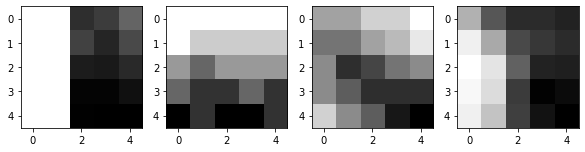

In [11]:
strip_left_row_sample = left_image_splitted[10*l_cols:10*l_cols+l_cols,:,:] # from the 10th line

print(strip_left_row_sample.shape)
fig, (img1, img2, img3, img4) = plt.subplots(1, 4)
img1.imshow(strip_left_row_sample[0,:,:], cmap = plt.cm.binary)
img2.imshow(strip_left_row_sample[10,:,:], cmap = plt.cm.binary)
img3.imshow(strip_left_row_sample[50,:,:], cmap = plt.cm.binary)
img4.imshow(strip_left_row_sample[100,:,:], cmap = plt.cm.binary)

**Hint:** For a clearer results, increase the block size when split the image

### "Best matching X" routine

Now the routine will be implemented using the splitted to make the analysis.

1 - Get the patch from the left image and find the corresponding line (of strip)  
2 - Get the patches from the right image, cropping the matrix to the corresponding line  
3 - Make the *Squared sum of difference* in the selected set  
4 - Get the index with the shortest value

In [12]:
def best_match_x(patch_left, patches_right, row, number_cols):
    patch_size = patch_left.shape
    begin_crop = row * number_cols
    end_crop = begin_crop + number_cols
    
    stripe_right = patches_right[begin_crop:end_crop, :,:]
    ssd = np.sum(np.sum((patch_left - stripe_right)**2, axis=2), axis=1)
    
    return np.argmin(ssd)

In [13]:
line = 1 # 1st line
patch_at_line = line * r_cols + 10 # 10th col

test_best_match = best_match_x(left_image_splitted[patch_at_line,:,:], right_image_splitted, line, r_cols)
test_best_match

203

### Disparity calculation

Now it is time to altogether in the disparity algorithm.

In [24]:
def disparity_ssd(img_left, img_right, block):
    
    start_time = time.time()
    # pad the images
    padded_img_left = padding_image(img_left, block)
    padded_img_right = padding_image(img_right, block)

    # Split the images in the 3D matrix patches
    left_patches, num_cols, num_rows = split_images_in_patches(padded_img_left, block)
    right_patches, _, _ = split_images_in_patches(padded_img_right, block)
    
    # Create the zero array which will store the disparities
    disparities = np.zeros((num_rows, num_cols))
    
    # Loop throught the left 3D matrix
    num_patches = left_patches.shape[0]
    
    for p in range(num_patches):
        # Get the row number of the current patch
        current_row = p // num_cols
        current_col = p - current_row * num_cols
        
        current_patch_left = left_patches[p, :, :]
        
        begin_col = current_row * num_cols
        end_col = begin_col + num_cols
        current_stripe_right = right_patches[begin_col:end_col, :, :]
        
        best_x = best_match_x(current_patch_left, right_patches, current_row, num_cols)
        
        disparities[current_row][current_col] = current_col - best_x
        
    end_time = time.time()
    print(str(end_time - start_time) + " seconds")
        
    return disparities

In [25]:
D_L = disparity_ssd(left_image, right_image, 7)
L_D = disparity_ssd(right_image, left_image, 7)

64.5765221118927 seconds
59.84582185745239 seconds


In [35]:
def normalize(matrix):
    return (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix))

D_L = normalize(D_L)
L_D = normalize(L_D)

In [37]:
cv2.imwrite('./output/D_L_1.png',D_L)
cv2.imwrite('./output/L_D_1.png',L_D)

True

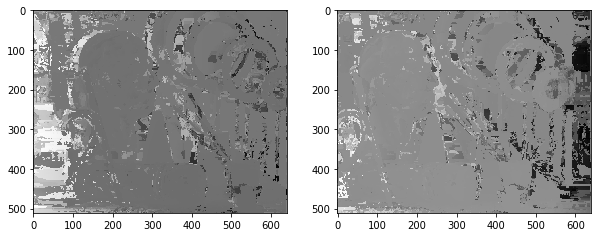

In [38]:
fig, (img1, img2) = plt.subplots(1, 2)
img1.imshow(normalize(D_L), cmap = plt.cm.binary)
img2.imshow(normalize(L_D), cmap = plt.cm.binary)

In [39]:
print(normalize(D_L))

[[0.50118765 0.50118765 0.50118765 ... 0.78226445 0.78226445 0.54869359]
 [0.50118765 0.50118765 0.50118765 ... 0.78226445 0.78147268 0.78226445]
 [0.50118765 0.50118765 0.50118765 ... 0.78226445 0.78226445 0.78068092]
 ...
 [0.50118765 0.50118765 0.50118765 ... 0.50118765 0.50118765 0.50118765]
 [0.50118765 0.50118765 0.50118765 ... 0.50118765 0.50118765 0.50118765]
 [0.50118765 0.50118765 0.50118765 ... 0.50118765 0.50118765 0.50118765]]
